In [1]:
import numpy as np
import pandas as pd
import cv2
import glob as gb
import os
import matplotlib.pyplot as plt

In [2]:
def getcode(n):
    for x,y in code.items() :
        if n==y :
            return x

In [3]:
s=48
code={'anger':0,'contempt':1,'disgust':2,'fear':3,'happy':4,'sadness':5,'surprise':6}
X_train=[]
y_train=[]
train_dir=r'C:/Users/importante/ck/ckdataset/'
for folder in os.listdir(train_dir):
    files=gb.glob(pathname=str(train_dir+folder+'/*.png'))
    for file in files :
        image=cv2.imread(file)
        X_train.append(list(cv2.resize(image,(s,s))))
        y_train.append(code[folder])

X_train=np.array(X_train)
y_train=np.array(y_train)

In [4]:
X_train=X_train/255.0

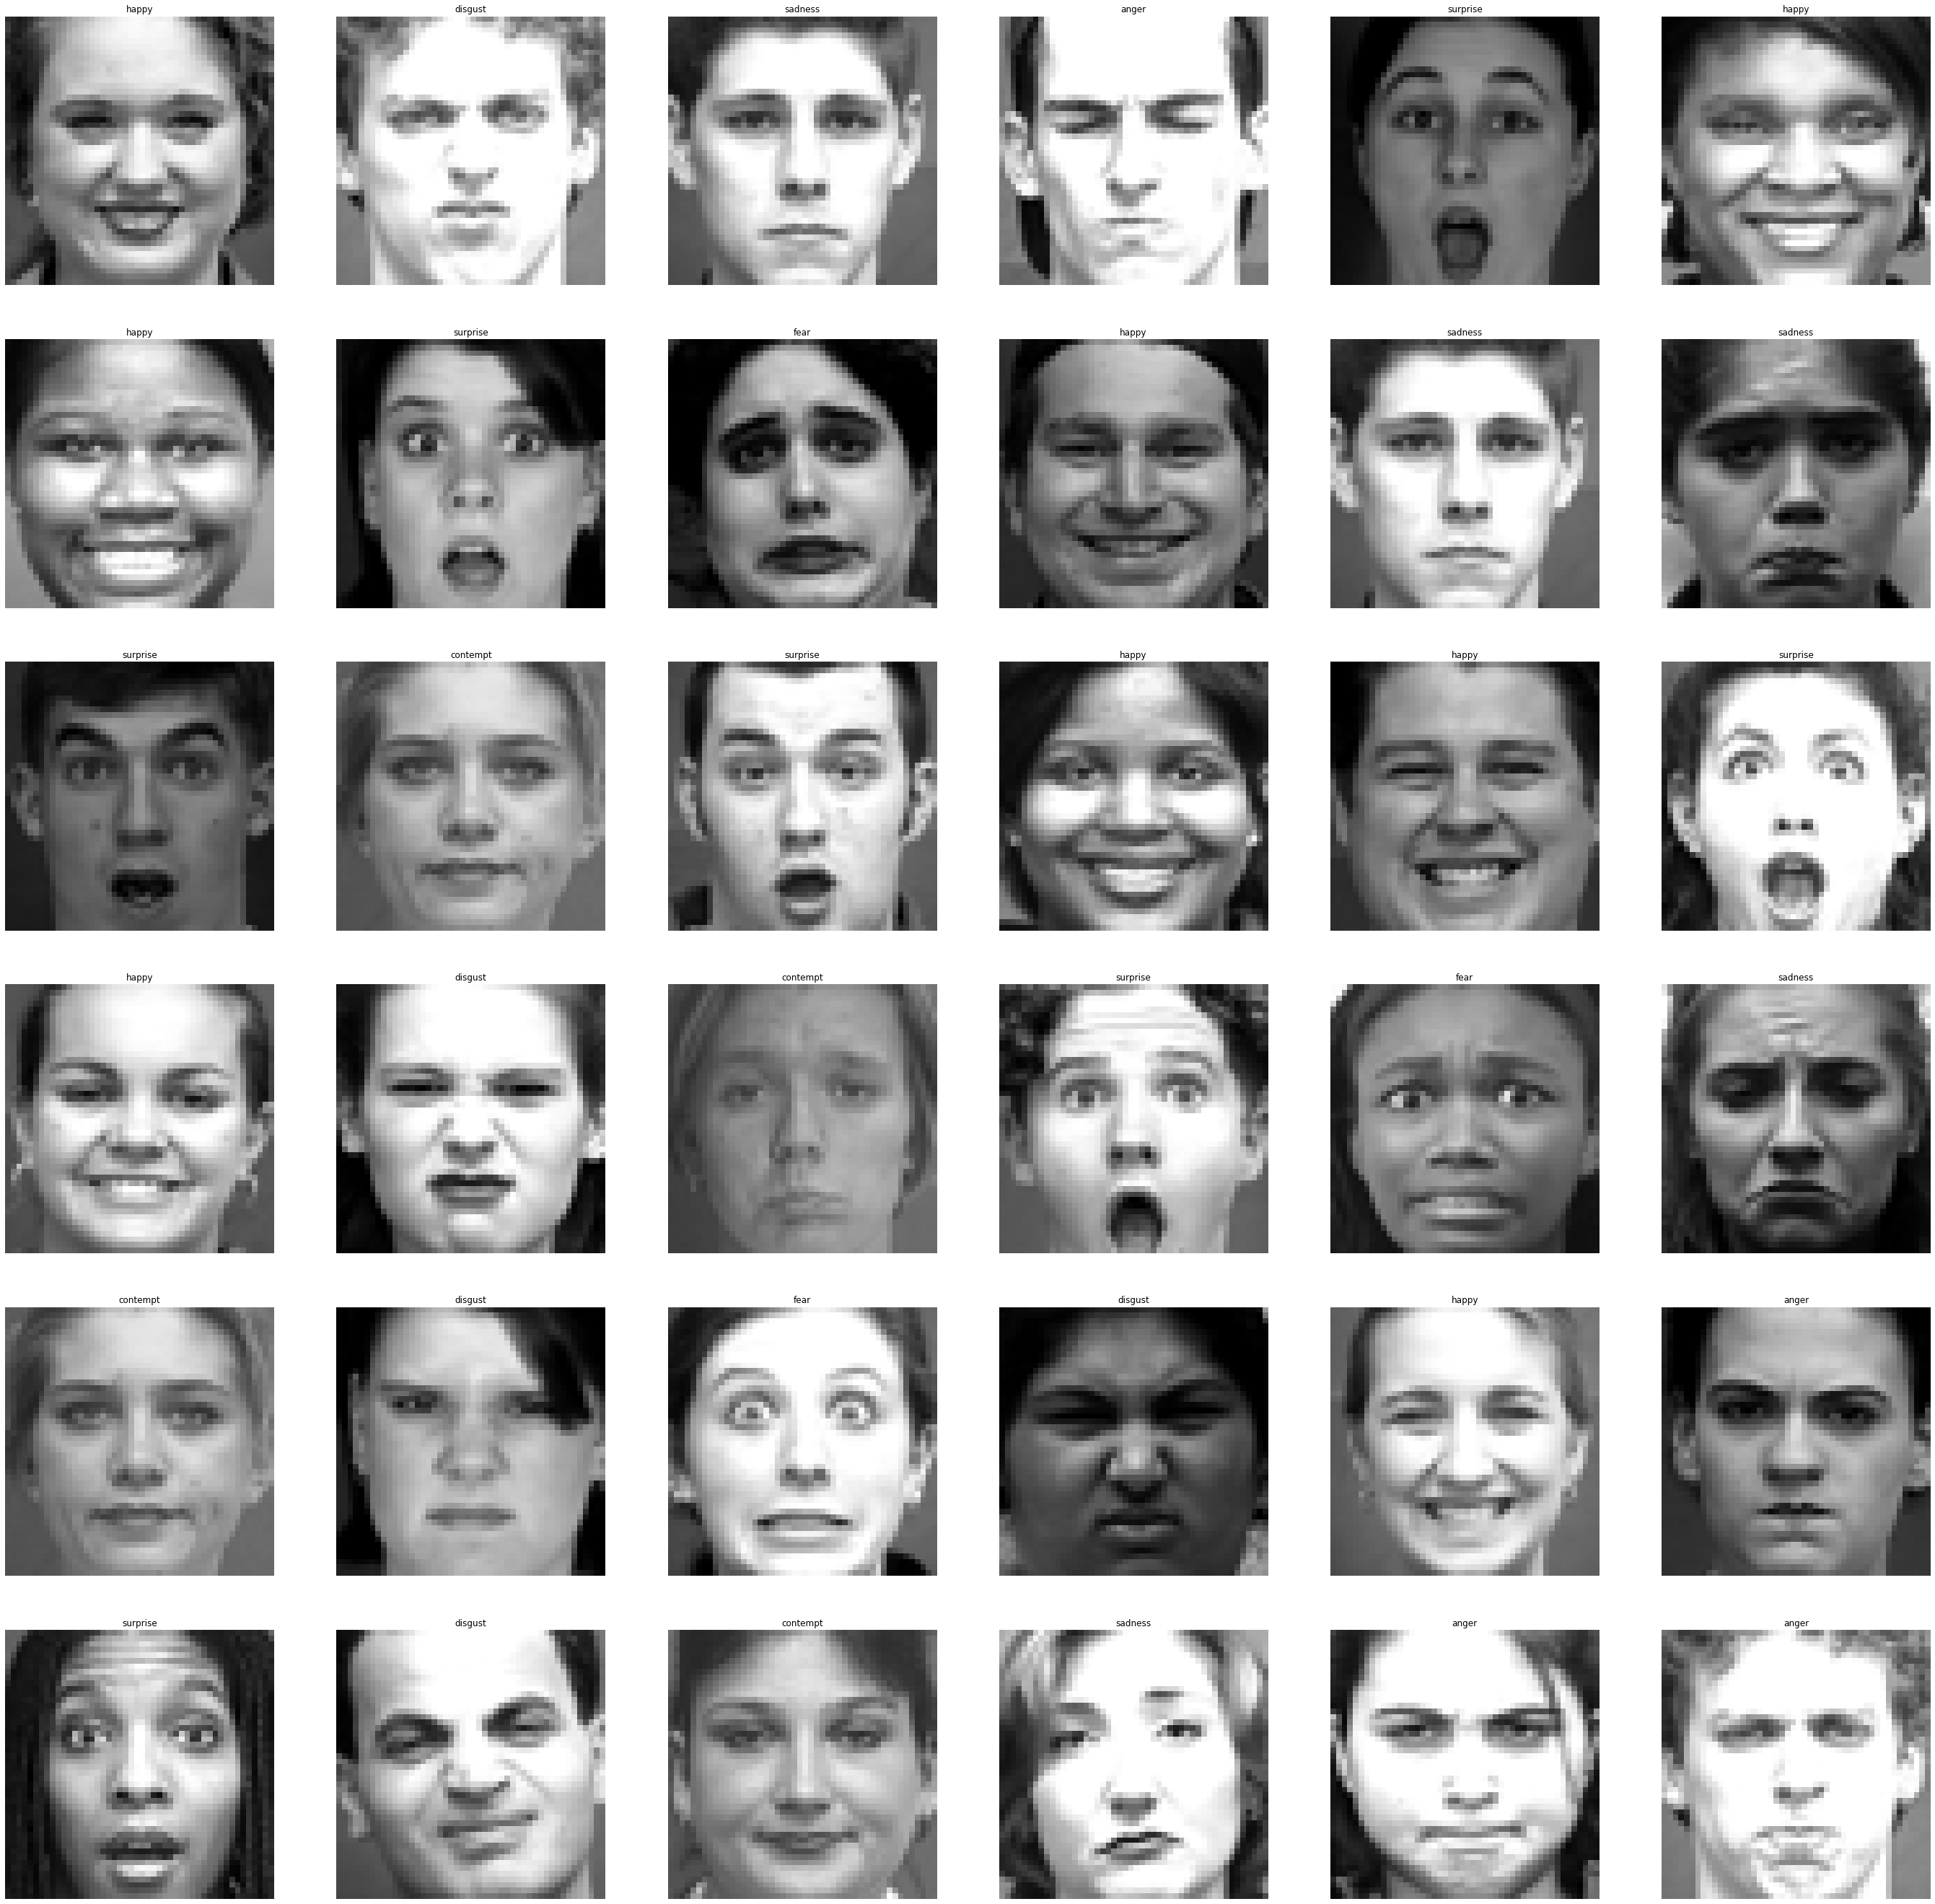

In [5]:
plt.figure(figsize=(48,48))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(getcode(y_train[i]))

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow(X_train,y_train,batch_size=8,shuffle=True)

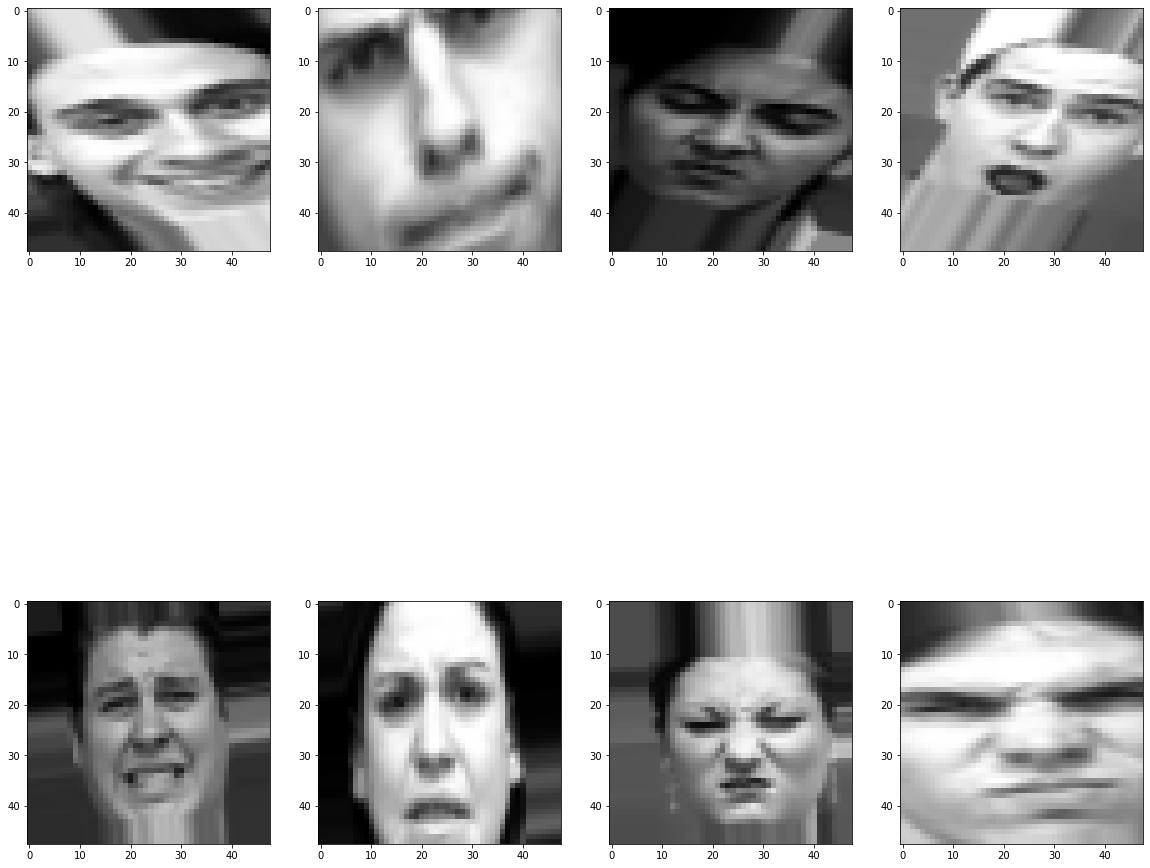

In [7]:
plt.figure(figsize=(20, 20))
for X_batch, y_batch in train_generator:

    for i in range(0, 8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])

    plt.show()
    break

In [8]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
X_train=np.array(X_train).reshape(-1, 48, 48, 3)

print("X_train shape2: ", X_train.shape)


X_train shape:  (981, 48, 48, 3)
y_train shape:  (981,)
X_train shape2:  (981, 48, 48, 3)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint


import numpy as np
import pandas as pd
import os
import glob as gb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [10]:
def get_model(input_size, classes=7):
 
    model = tf.keras.models.Sequential() 
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(728, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [12]:
model = get_model((48,48,3), 7)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        3

In [13]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, 
                    batch_size=8 , 
                    epochs=50, 
                    validation_data = (X_train, y_train), 
                    callbacks = [callbacks],
                    shuffle=True)

Epoch 1/50
123/123 [==============================] - 71s 570ms/step - loss: 23.6082 - accuracy: 0.1967 - val_loss: 19.2983 - val_accuracy: 0.2559 - lr: 0.0010
Epoch 2/50
123/123 [==============================] - 67s 544ms/step - loss: 15.2212 - accuracy: 0.2406 - val_loss: 11.6652 - val_accuracy: 0.2385 - lr: 0.0010
Epoch 3/50
123/123 [==============================] - 68s 555ms/step - loss: 10.6588 - accuracy: 0.1957 - val_loss: 8.3576 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 4/50
123/123 [==============================] - 67s 548ms/step - loss: 7.2778 - accuracy: 0.2742 - val_loss: 6.1357 - val_accuracy: 0.0826 - lr: 0.0010
Epoch 5/50
123/123 [==============================] - 68s 552ms/step - loss: 5.1919 - accuracy: 0.3282 - val_loss: 4.7927 - val_accuracy: 0.2946 - lr: 0.0010
Epoch 6/50
123/123 [==============================] - 69s 558ms/step - loss: 4.0972 - accuracy: 0.3700 - val_loss: 4.0849 - val_accuracy: 0.2151 - lr: 0.0010
Epoch 7/50
123/123 [===========================

In [36]:
model.evaluate(train_generator)

123/123 [==============================] - 8s 68ms/step - loss: 0.7186 - accuracy: 0.8603


[0.7186008095741272, 0.8603465557098389]

In [37]:
model.evaluate(X_train,y_train)

31/31 [==============================] - 5s 171ms/step - loss: 0.5498 - accuracy: 0.9246


[0.5497793555259705, 0.9245667457580566]

In [40]:
model.save_weights('a1.h5')

In [41]:
model.save("a2.hdf5")
print("Saved model to disk")

Saved model to disk


In [42]:
model.save_weights('a3.hdf5')

In [ ]:
model.save('a4.h5')